In [23]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

# 0. Read dataset

In [2]:
# path_csv = r"Dataset/tidyData_fe3.csv"
path_train_csv = r"Dataset/train.csv"
path_val_csv = r"Dataset/val.csv"

In [3]:
df_train = pd.read_csv(path_train_csv)
print(f"Shape of df_train: {df_train.shape}")

df_val = pd.read_csv(path_val_csv)
print(f"Shape of df_val: {df_val.shape}")

df_train.sample(5)

Shape of df_train: (253475, 32)
Shape of df_val: (73867, 32)


,Unnamed: 0,gamePk,homeTeam,period,periodType,periodTime,periodTimeRemaining,dateTime,teamId,teamName,attackingSide,teamTriCode,eventType,x-coordinate,y-coordinate,goalieName,shooterName,shotType,isEmptyNet,strength,shot_distance,angle,isgoal,last_event_type,coor_x_last_event,coor_y_last_event,time_last_event,distance_last_event,is_rebound,Change in shot angle,Speed,season
102422,234023,2018020979,Toronto Maple Leafs,1,REGULAR,16:57,03:03,2019-02-28T00:42:56Z,10,Toronto Maple Leafs,left,TOR,Shot,-63.0,-14.0,Mikko Koskinen,Morgan Rielly,Wrist Shot,0,False,29.529646,-0.493941,0,Missed Shot,-73.0,15.0,6.0,30.675723,True,-0.367349,5.112621,2018
430,430,2017021142,Nashville Predators,3,REGULAR,19:54,00:06,2018-03-23T02:40:54Z,18,Nashville Predators,right,NSH,Shot,13.0,-6.0,Frederik Andersen,P.K. Subban,Slap Shot,0,False,76.236474,-0.078784,0,Giveaway,-21.0,-2.0,11.0,34.234486,True,-0.743558,3.112226,2017
216457,348058,2016020953,Buffalo Sabres,1,REGULAR,03:37,16:23,2017-03-05T00:14:39Z,14,Tampa Bay Lightning,left,TBL,Shot,-32.0,-36.0,Robin Lehner,Braydon Coburn,Snap Shot,0,False,67.416615,-0.563316,0,Blocked Shot,-74.0,-2.0,5.0,54.037024,True,0.031443,10.807405,2016
125842,257443,2018020271,Los Angeles Kings,3,REGULAR,06:56,13:04,2018-11-14T05:42:30Z,26,Los Angeles Kings,left,LAK,Shot,-82.0,-12.0,Frederik Andersen,Jake Muzzin,Wrist Shot,0,False,13.892444,-1.042722,0,Shot,-78.0,-4.0,3.0,8.944272,True,-1.018774,2.981424,2018
125580,257181,2018020334,New Jersey Devils,3,REGULAR,09:09,10:51,2018-11-23T23:19:46Z,1,New Jersey Devils,right,NJD,Shot,61.0,32.0,Thomas Greiss,Kyle Palmieri,Wrist Shot,0,False,42.520583,0.851966,0,Faceoff,69.0,-22.0,31.0,54.589376,True,0.557732,1.760948,2018


In [4]:
df_train.dropna(inplace=True)
df_val.dropna(inplace=True)

print(f"AFTER drop nan samples")
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_val: {df_val.shape}")

AFTER drop nan samples
Shape of df_train: (244497, 32)
Shape of df_val: (69968, 32)


- There are 4% of samples containing NaN value. It is fine to remove all of NaN samples.

# 1. Add more feature

- In this section, we will add the new feature called `attacking_zone_shot`. This feature indicates whether the shot occurred in the attacking zone.
- We choose to analyze this feature based on the observation that the shot in the attacking zone has high chance to become a goal.
- **After analyzing**, we realize that 94.5% shot happend inside attacking zone, and 5% shot happened outside attacking zone.

In [5]:
def Is_Shot_In_Attacking_Zone(x_coordinate_shot, attacking_side):

    if str(attacking_side).lower() == "left":
        x_coordinate_net = -89
        attacking_zone_range = -25
        return x_coordinate_net <= x_coordinate_shot <= attacking_zone_range
    elif str(attacking_side).lower() == "right":
        x_coordinate_net = 89
        attacking_zone_range = 25
        return  attacking_zone_range <= x_coordinate_shot <= x_coordinate_net
    else:
        return None

In [6]:
df_train['attacking_zone_shot'] = df_train.apply(lambda x: Is_Shot_In_Attacking_Zone(x['x-coordinate'], x['attackingSide']), axis=1)
df_val['attacking_zone_shot'] = df_val.apply(lambda x: Is_Shot_In_Attacking_Zone(x['x-coordinate'], x['attackingSide']), axis=1)

# 2. Feature selection

- In this section, I will use **correlation** and **mutual information** to perform the feature selection.

### a. Correlation

- In this section, we will check the correlation value between pairs of features. If the correlation between two features are larger than specific `threshold`, we will remove it.

In [7]:
list_features = ['period', 'x-coordinate', 'y-coordinate', 'shot_distance', 'angle', 'last_event_type', 'coor_x_last_event',\
                 'coor_y_last_event', 'time_last_event', 'distance_last_event', 'is_rebound', 'Change in shot angle', 'Speed']

labels = 'isgoal'

In [8]:
X_train = df_train[list_features]
y_train = df_train[labels]

X_val = df_val[list_features]
y_val = df_val[labels]

In [9]:
def List_High_Corr_Features(df, threshold=0.9):

    # Find numerical features
    numerical_features = df.select_dtypes(include=['int', 'float']).columns
    df = df[numerical_features]

    corr_matrix = df.corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    drop_features = [column for column in upper.columns if any(upper[column] > threshold)]
    # X = X.drop(drop_features, axis=1)

    return drop_features

In [10]:
# Remove high correlation features
threshold = 0.9
drop_features = List_High_Corr_Features(X_train, threshold=threshold)
print(f"[INFO] Drop high correlation: {drop_features}")

X_train = X_train.drop(drop_features, axis=1)
X_val = X_val.drop(drop_features, axis=1)

# categorical_features = ['last_event_type', 'is_rebound']
# numerical_features = [i for i in list(X.columns) if i not in categorical_features]

[INFO] Drop high correlation: []


### b. Mutual information

- On this section, we will use mutual information to identify the relationship between features and the target variable. 
- From practical visualization, we will choose features, whose mutual information scores are above 0.01.

In [11]:
numerical_features = X_train.select_dtypes(include=['int', 'float']).columns
categorical_features = [i for i in list(X_train.columns) if i not in numerical_features]

X_train_numerical = X_train[numerical_features]
X_train_categorical = X_train[categorical_features]

X_val_numerical = X_val[numerical_features]
X_val_categorical = X_val[categorical_features]

In [12]:
# Calculate mutual information
mi_selector = SelectKBest(mutual_info_classif, k='all')
mi_selector.fit(X_train_numerical, y_train)

# Remove feature with threshold smaller than threshold
threshold_mi = 0.01
selected_features = X_train_numerical.columns[mi_selector.scores_ > threshold_mi]
print(f"Selected features (mutual information): {selected_features}")

X_train_numerical = X_train_numerical[selected_features]
X_val_numerical = X_val_numerical[selected_features]

Selected features (mutual information): Index(['period', 'x-coordinate', 'y-coordinate', 'shot_distance', 'angle'], dtype='object')


# c. Convert categorical feature into one-hot vector

In [13]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_train_categorical)

X_train_categorical = encoder.transform(X_train_categorical).toarray()
X_val_categorical = encoder.transform(X_val_categorical).toarray()

## d. Convert numerical features

In [14]:
scaler = StandardScaler()
scaler.fit(X_train_numerical)

X_train_numerical = scaler.transform(X_train_numerical)
X_val_numerical = scaler.transform(X_val_numerical)

In [15]:
X_train = np.concatenate([X_train_numerical, X_train_categorical], axis=1)
X_val = np.concatenate([X_val_numerical, X_val_categorical], axis=1)

# 3. Building machine learning model

- In this section, we will use **Decision tree**.


In [16]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

DecisionTreeClassifier()

### a. Evaluation

In [17]:
y_val_pred = clf.predict(X_val)

accuracy = accuracy_score(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.88
Confusion Matrix:
[[60768  2906]
 [ 5834   460]]


# 4. Grid search decision tree

In [44]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 15]
}

In [45]:
dt_classifier = DecisionTreeClassifier()

grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='f1_micro')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_dt_classifier = grid_search.best_estimator_

In [46]:
y_val_pred = best_dt_classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)

print("Best Parameters:", best_params)
print(f"Accuracy validation set: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)    

Best Parameters: {'criterion': 'entropy', 'max_depth': 10}
Accuracy validation set: 0.91
Confusion Matrix:
[[63591    83]
 [ 6254    40]]


# 5. Visualization

In [47]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# a. ROC and AUC

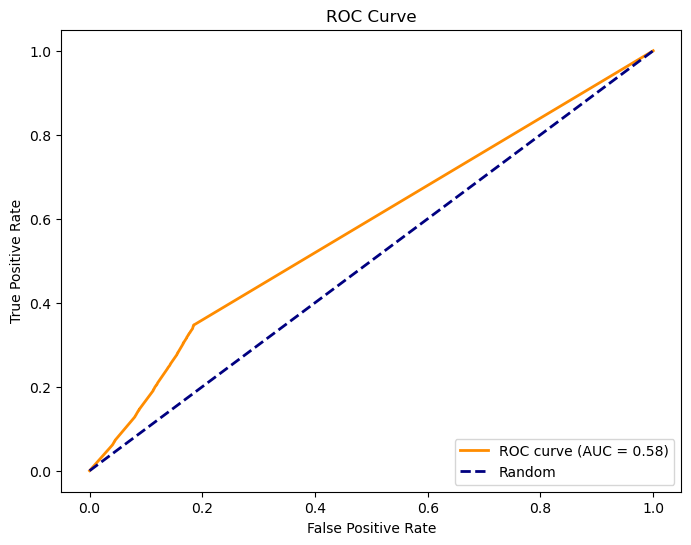

AUC: 0.5784448959053115


In [48]:
y_prob = clf.predict_proba(X_val)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Display AUC score
print('AUC:', roc_auc_score(y_val, y_prob))

### b. Goal rate

In [52]:
y_val_pre_proba = best_dt_classifier.predict_proba(X_val)[:, 1]
y_val_pre_proba

array([0.09594595, 0.01735509, 0.01575967, ..., 0.        , 0.        ,
       0.03      ])

In [65]:
df_goal_rate = pd.DataFrame({'shot_probability': y_val_pre_proba,\
                             'goal': y_val})

df_goal_rate = df_goal_rate.sort_values(by='shot_probability')
df_goal_rate.reset_index(inplace=True, drop=True)

df_goal_rate

,shot_probability,goal
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
...,...,...
69963,1.0,0
69964,1.0,0
69965,1.0,0
69966,1.0,0


In [69]:
df_goal_rate['cumulative_goals'] = df_goal_rate['goal'].cumsum()
df_goal_rate['cumulative_shots'] = list(1 + df_goal_rate.index)

# Calculate the goal rate at each percentile
df_goal_rate['goal_rate'] = df_goal_rate['cumulative_goals'] / df_goal_rate['cumulative_shots']

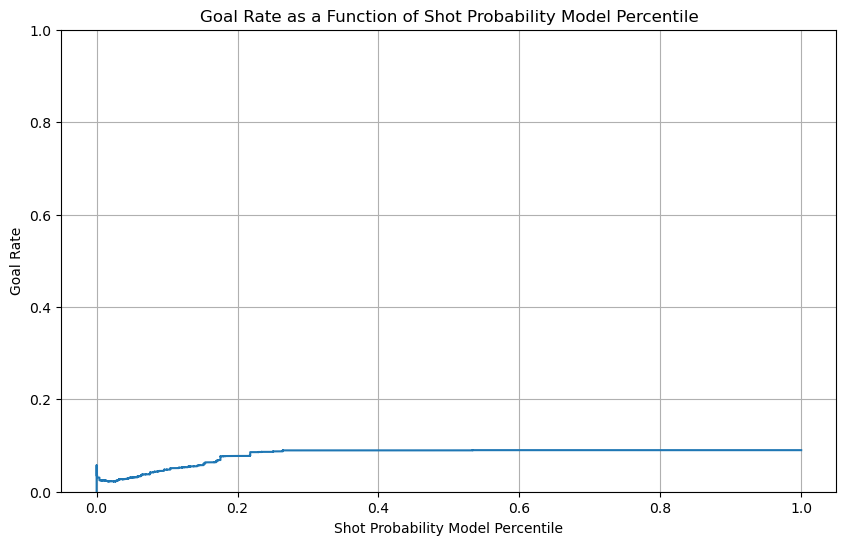

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(df_goal_rate['shot_probability'], df_goal_rate['goal_rate'])
plt.ylim(0.0, 1.0)
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Goal Rate')
plt.title('Goal Rate as a Function of Shot Probability Model Percentile')
plt.grid(True)
plt.show()

### c. 

In [75]:
df_goal_rate

,shot_probability,goal,cumulative_goals,cumulative_shots,goal_rate
0,0.0,0,0,1,0.000000
1,0.0,0,0,2,0.000000
2,0.0,0,0,3,0.000000
3,0.0,0,0,4,0.000000
4,0.0,0,0,5,0.000000
...,...,...,...,...,...
69963,1.0,0,6294,69964,0.089961
69964,1.0,0,6294,69965,0.089959
69965,1.0,0,6294,69966,0.089958
69966,1.0,0,6294,69967,0.089957


In [76]:
total_goals = df_goal_rate['goal'].sum()

# Calculate the cumulative proportion of goals at each percentile
df_goal_rate['cumulative_proportion_goals'] = df_goal_rate['cumulative_goals'] / total_goals

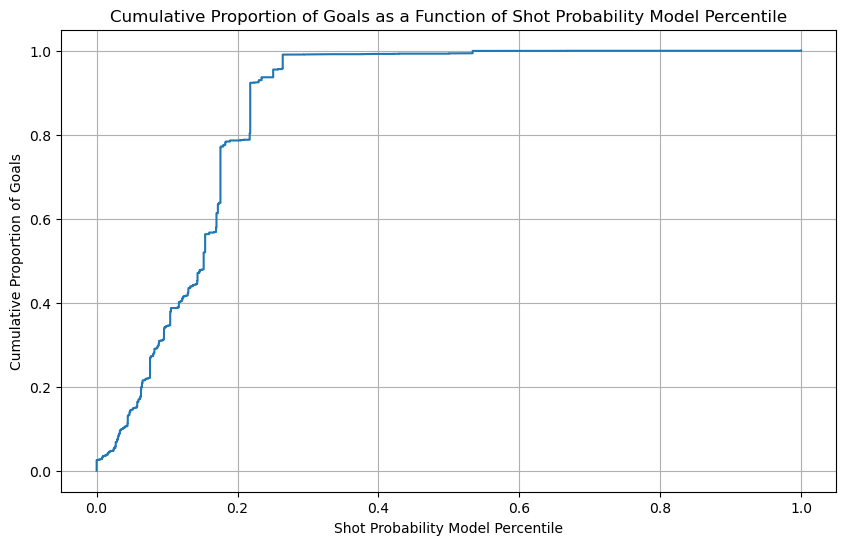

In [77]:
# Plot the cumulative proportion of goals as a function of the shot probability model percentile
plt.figure(figsize=(10, 6))
plt.plot(df_goal_rate['shot_probability'], df_goal_rate['cumulative_proportion_goals'])
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Cumulative Proportion of Goals')
plt.title('Cumulative Proportion of Goals as a Function of Shot Probability Model Percentile')
plt.grid(True)
plt.show()
